<a href="https://colab.research.google.com/github/shilpasy/BioEmbed-HuggingFace-Projects/blob/main/huggingface_embedding_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome to the 1st section of BioEmbed-HuggingFace-Projects, a simple demonstration of using Hugging Face's transformers to cluster protein sequences.
I hope this serves as an informative and inspiring introduction to the exciting world of Hugging Face, protein analysis, and embeddings in the context of bioinformatics.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd

train = pd.read_csv('/content/drive/My Drive/kaggle_data/novozymes-enzyme-stability-prediction/train.csv')

In [3]:
train.head(2)

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5


In [4]:
train['seq_len'] = [len(i) for i in train['protein_sequence']]
seq_len_stat = train['seq_len'].describe(percentiles = [0.05, 0.25, 0.50, 0.75, 0.90])
seq_len_stat

count    31390.000000
mean       447.669513
std        640.728935
min          5.000000
5%         101.000000
25%        197.000000
50%        336.000000
75%        523.000000
90%        838.000000
max      32767.000000
Name: seq_len, dtype: float64

<Axes: xlabel='seq_len', ylabel='Count'>

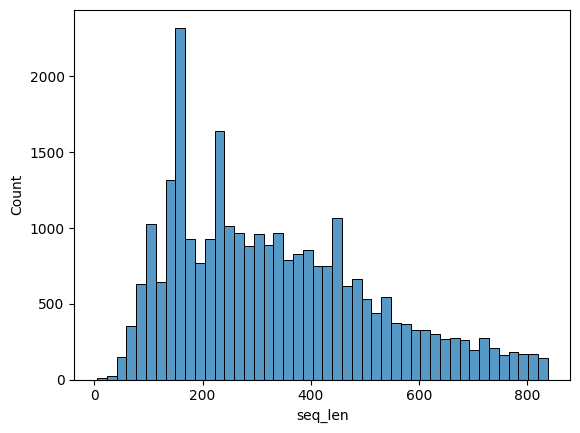

In [5]:
import seaborn as sns
train = train[train['seq_len'] <= 838].reset_index(drop=True)
sns.histplot(train.seq_len)

In [ ]:
train['seq_len'].quantile(0.9)

In [ ]:
#train.loc[train['seq_len'].idxmax()]['protein_sequence']

The minimum length of the protein sequence is 5 and maximum is >30,000. Looks like there could be some issue in the training dataset.
We can resolve the issues later, for now we can get rid of outliers.
I am using a very narrow sequence range here so that it runs quickly.

In [6]:
# There are other ways to deal with outliers but for simplicity we are going to drop them here, because the values are extreme and its likely that there is some issue with those sequences. Also there are very few such outliers
print(f"shape of train: {train.shape}")
# Filter out rows manually with the requited length or discarding the too big and too small sequences
#toolonglen = train['seq_len'].quantile(0.9)
toolonglen = 180
train = train[train['seq_len'] <= toolonglen].reset_index(drop=True)
#tooshortlen = train['seq_len'].quantile(0.1)
tooshortlen = 170
train = train[train['seq_len'] >=tooshortlen].reset_index(drop=True)
print(f"shape of train after filtering out the outliers: {train.shape}")

shape of train: (28257, 6)
shape of train after filtering out the outliers: (566, 6)


**Use the transformers library to load the ProtBert model and tokenizer**

In [7]:
from transformers import BertTokenizer, BertModel
import torch # Why are we importing torch here? : The torch library is used in the ProtBert script for handling tensors.
             # When using the transformers library to load a model, the inputs are expected to be PyTorch tensors. The ProtBert model, like other models in the Hugging Face transformers library, is designed to work seamlessly with PyTorch

model_name = "Rostlab/prot_bert"
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=False)
model = BertModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

    What is a transformers library?

The transformers library, created by Hugging Face, is a powerful and popular open-source library for natural language processing (NLP) tasks.

The transformers library is like a toolbox for working with languages. It contains pre-trained models that can help you with tasks like translation, summarization, and sentiment analysis. In this specific case, we leverage the library to access a pre-trained model specialized in understanding protein sequences, showcasing the versatility of the toolkit for various domains.

    What is ProtBert
a specific type of language model, similar to BERT (Bidirectional Encoder Representations from Transformers), designed to understand and generate representations for protein sequences. It's trained on a large amount of protein-related text data, enabling it to capture complex patterns and relationships within protein sequences.


**Define a Function to Get ProtBert Embeddings:**

In [8]:
def get_huggingface_protbert_embeddings(sequence, model, tokenizer):
    inputs = tokenizer(sequence, return_tensors='pt', padding=True, truncation=True)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Average pooling over sequence length (averages the amino acid-wise embeddings across sequence)
   # embeddings = outputs.last_hidden_state[:, 0, :]  # Use [CLS] token embedding

    return embeddings.detach().numpy()

    Why Tokenizer is Necessary:
A tokenizer is essential for converting raw protein sequences into a format understandable by ProtBert. It breaks down the sequences into smaller units called tokens, allowing the model to process and analyze the sequences effectively. The tokenizer is a crucial intermediary step in preparing the input for the language model. It is like breaking down a sentence into words.

    How Sequence Embeddings Work:
They are numerical representations of protein sequences that capture semantic information. ProtBert processes the sequences and produces embeddings where each number in the vector represents a feature or characteristic of the sequence. These embeddings encode contextual information, allowing the model to understand relationships between amino acids in the protein.


Get ProtBert Embeddings for Each Protein Sequence



In [11]:
train['protein_sequences_spaced'] = [' '.join(list(s)) for s in train['protein_sequence']] ## ProtTrans needs spaces between amino acid letters

# ------------commenting this section because I have already saved the embedding array----------
#embeddings_list = [get_huggingface_protbert_embeddings(seq, model, tokenizer) for seq in train['protein_sequences_spaced']]
#embeddings_array = np.vstack(embeddings_list)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
#embeddings_array[1:3]

In [24]:
#np.save('/content/drive/My Drive/kaggle_data/novozymes-enzyme-stability-prediction/embeddings_array_spaced_CLS.npy', embeddings_array)
loaded_embeddings = np.load('/content/drive/My Drive/kaggle_data/novozymes-enzyme-stability-prediction/embeddings_array_spaced.npy')
#np.savetxt('embeddings_array.txt', embeddings_array)

In [25]:
loaded_embeddings[1:3]

array([[ 0.04218493,  0.03345479, -0.02088467, ..., -0.04227312,
         0.00762322,  0.01489731],
       [ 0.01599251, -0.03253815,  0.02571723, ...,  0.01800458,
         0.01496154, -0.00256919]], dtype=float32)

Apply UMAP for dimensionality reduction

In [ ]:
#!pip install umap-learn

In [26]:
from sklearn.preprocessing import MinMaxScaler
import umap

# Scale the embeddings
#embeddings_scaled = MinMaxScaler().fit_transform(embeddings_array)
embeddings_scaled = MinMaxScaler().fit_transform(loaded_embeddings)

umap_model = umap.UMAP(n_components=2, metric='cosine', random_state=0)
umap_result = umap_model.fit_transform(embeddings_scaled)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [27]:
from sklearn.cluster import KMeans

# Perform clustering on the UMAP result
kmeans = KMeans(n_clusters=3, random_state=12, n_init= 'auto')
cluster_labels = kmeans.fit_predict(umap_result)

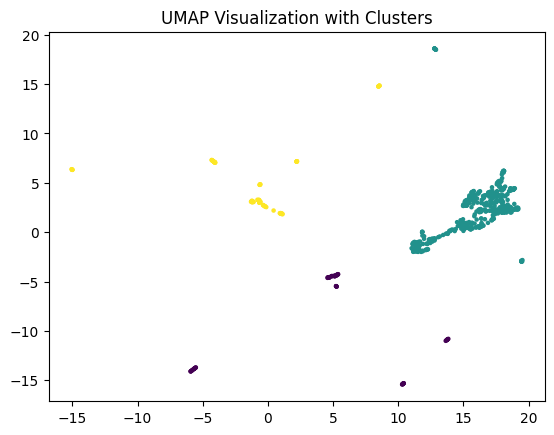

In [28]:
import matplotlib.pyplot as plt
# Visualize UMAP result
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=cluster_labels, cmap='viridis', s=5)
plt.title('UMAP Visualization with Clusters')
plt.show()

    Advantages of Embedding-Based Clustering vs. Traditional MSA-Based Clustering:
Embedding-based clustering uses learned representations (embeddings) of sequences, like those produced by ProtBert, to group similar sequences together. This approach has advantages over traditional Multiple Sequence Alignment (MSA)-based clustering because embeddings capture complex features and relationships, even in sequences with varying lengths. Embedding-based methods often perform well without the need for explicit alignment steps, making them more flexible and applicable to diverse data.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


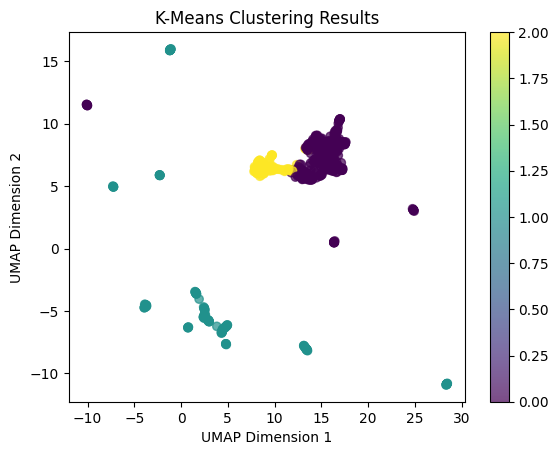

In [30]:
# WE can also perform clustering directly without UMAP
kmeans = KMeans(n_clusters=3, random_state=1204,  n_init = 'auto')
cluster_labels = kmeans.fit_predict(embeddings_scaled)

# Plot the results using UMAP for visualization
umap_model = umap.UMAP(n_components=2, metric='cosine', random_state=0)
umap_result = umap_model.fit_transform(embeddings_scaled)
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title('K-Means Clustering Results')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar()